Credit Loan Allocation
=====================

Based on the [Credit Loan Decisions](https://fairlearn.org/v0.10/auto_examples/plot_credit_loan_decisions.html#sphx-glr-auto-examples-plot-credit-loan-decisions-py), Fearlearn.


Package Imports
===============


In [1]:
import os
import sys

from typing import (
    Tuple,
    List, 
    Dict,
    Any, 
    Union
)    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed: int = 1234
np.random.seed(rand_seed)

Fairness considerations of credit loan decisions
================================================

Fairness and credit lending in the US
-------------------------------------

In 2019, Apple received backlash on social media after its newly
launched *Apple Card* product appeared to offer higher credit limits to
men compared to women `nedlund2019apple`{.interpreted-text
role="footcite"}. In multiple cases, married couples found the husband
received a credit limit that was 10-20x higher than the wife\'s even
when the couple had joint assets.

From a regulatory perspective, financial institutions that operate
within the United States are subject to *legal regulations* prohibiting
discrimination on the [basis of race, gender, or other protected classes
:footcite:\`uscode2011title15chapter41subchapteriv]{.title-ref}. With
the increasing prevalence of automated decision-systems in the financial
lending space, experts have raised concerns about whether these systems
could exacerabate existing inequalities in financial lending.

Although the two concepts are intertwined, algorithmic fairness is not
the same concept as anti-discrimination law. An AI system can comply
with anti-discrimination law while exhibiting fairness-related concerns.
On the other hand, some fairness interventions may be illegal under
anti-discrimination law.
:footcite`Xiang2019legalcompatibility`{.interpreted-text role="cts"}
discuss the compatibilities and disconnects between anti-discrimination
law and algorithmic notions of fairness. In this case study, we focus on
fairness in financial services rather than compliance with financial
anti-discrimination regulations.

Ernst & Young (EY) case study
=============================

In this case study, we aim to replicate the work done in a white paper
`dudik2020assessing`{.interpreted-text role="footcite"}, co-authored by
*Microsoft* and *EY*, on mitigating gender-related performance
disparities in financial lending decisions. In their analysis, Microsoft
and EY demonstrated how Fairlearn could be used to measure and mitigate
unfairness in the loan adjudication process.

Using a dataset of credit loan outcomes (whether an individual defaulted
on a credit loan), we train a fairness-unaware model to predict the
likelihood an individual will default on a given loan. We use the
Fairlearn toolkit for assessing the fairness of our model, according to
several metrics. Finally, we perform two unfairness mitigation
strategies on our model and compare the results to our original model.

Because the dataset used in the white paper is not publicly available,
we will introduce a semi-synthetic feature into an existing publicly
available dataset to replicate the outcome disparity found in the
original dataset.

Credit decisions dataset
------------------------

As mentioned, we will not be able to use the original loans dataset, and
instead will be working with a publicly available dataset of credit card
defaults in Taiwan collected in 2005. This dataset represents binary
credit card default outcomes for 30,000 applicants with information
pertaining to an applicant\'s payment history and bill statements over a
six-month period from April 2005 to September 2005, as well as
demographic information, such as *sex*, *age*, *marital status*, and
*education level* of the applicant. A full summary of features is
provided below:

![alt text](data/columns_def.png "Title")

Let\'s pretend we are a data scientist at a financial institution who is
tasked with developing a classification model to predict whether an
applicant will default on a personal loan. A positive prediction by the
model means the applicant would default on the credit loan. *Defaulting
on a loan* means the client fails to make payments within a 30-day
window, and the lender can take legal actions against the client.

Although we do not have a dataset of loan default history, we do have
this data set of credit card payment history. We assume customers who
make monthly credit card payments on time are more *creditworthy*, and
thus less likely to default on a personal credit loan.

**Decision point: task definition**

-   **Defaulting on a credit card payment** can be viewed as a proxy for
    the fact that an applicant might not be a good candidate for a
    personal loan.
-   Because most customers did not default on their credit card payment,
    we will need to take this class imbalance into account during our
    modeling process.

As the data is read in-memory, we will change the column `PAY_0` to
`PAY_1` to make the naming more consistent with the naming of the other
columns. In addition, the target variable `default payment next month`
is changed to `default` to reduce verbosity.


In [2]:
# define constants
PROKJECT_PATH: str = os.getcwd()
DATA_PATH: str = os.path.join(PROKJECT_PATH, 'data')
FILE_PATH: str = os.path.join(DATA_PATH, 'data.csv')

In [3]:
data_url: str = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

In [4]:
# create a data path if it doesn't exist
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [5]:
# download data if it's not in the \data folder yet, otherwise - read it from the \data folder
if not os.path.exists(FILE_PATH):
    df: pd.DataFrame = pd.read_excel(io=data_url, header=1)\
        .drop(columns=["ID"])\
        .rename(
            columns={"PAY_0": "PAY_1", "default payment next month": "default"}
        )
    df.to_csv(FILE_PATH, index=False)
else:
    df: pd.DataFrame = pd.read_csv(FILE_PATH)

print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 30000; columns: 24


In [6]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


From the [dataset description](
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients), we see there are three
categorical features:

-   `SEX`: Sex of the applicant (as a binary feature)
-   `EDUCATION`: Highest level of education achieved by the applicant.
-   `MARRIAGE`: Marital status of the applicant.


In [7]:
# define a list of categorical features
categorical_features: List[str] = ["SEX", "EDUCATION", "MARRIAGE"]

# convert categorical columns into category data type
for col_name in categorical_features:
    df[col_name] = df[col_name].astype("category")

In [8]:
# define 
# - Y - target
# - A - protected column
Y, A = df.loc[:, "default"], df.loc[:, "SEX"]

In [9]:
# define features
X: pd.DataFrame = pd.get_dummies(df.drop(columns=["default", "SEX"]))

In [10]:
print('X shape:')
print('without encoding: ', df.drop(columns=["default", "SEX"]).shape)

X shape:
without encoding:  (30000, 22)


In [11]:
print('after encoding: ', X.shape)

after encoding:  (30000, 31)


In [12]:
print('Sex:')
print('\nBefore decoding:\n', A.head())
A_str = A.map({1: "male", 2: "female"})
print('\nEncoded:\n', A_str.head())

Sex:

Before decoding:
 0    2
1    2
2    2
3    2
4    1
Name: SEX, dtype: category
Categories (2, int64): [1, 2]

Encoded:
 0    female
1    female
2    female
3    female
4      male
Name: SEX, dtype: category
Categories (2, object): ['male', 'female']


Dataset imbalances
==================

Before we start training a classifier model, we want to explore the
dataset for any characteristics that may lead to fairness-related harms
later on in the modeling process. In particular, we will focus on the
distribution of sensitive feature `SEX` and the target label `default`.

As part of an exploratory data analysis, let\'s explore the distribution
of our sensitive feature `SEX`. We see that 60% of loan applicants were
labeled as [female]{.title-ref} and 40% as [male]{.title-ref}, so we do
not need to worry about imbalance in this feature.


In [13]:
# distribution of the sensitive feature 'SEX'
A_str.value_counts(normalize=True)

SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64

Next, let\'s explore the distribution of the *loan default rate* `Y`. We
see that around 78% of individuals in the dataset do not default on
their credit loan. While the target label does not display extreme
imbalance, we will need to account for this imbalance in our modeling
section. As opposed to the *sensitive feature* `SEX`, an imbalance in
the target label may result in a classifier that over-optimizes for the
majority class. For example, a classifier that predicts an applicant
will not default would achieve an accuracy of 78%, so we will use the
`balanced_accuracy` score as our evaluation metric to counteract the
label imbalance.


In [14]:
# distribution of the target
Y.value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

Add synthetic noise that is related to the outcome and sex
==========================================================

For the purpose of this case study, we add a synthetic feature
`Interest` that introduces correlation between the `SEX` label of an
applicant and the `default` outcome. The purpose of this feature is to
replicate outcome disparities present in the original dataset. We can
think of this `Interest` feature as the *interest rate* for the
applicant. If the applicant has a history of defaulting on credit card
payments, the bank will lend to the applicant at a higher interest rate.
We also assume because banks have historically lended primarily to men,
there is less uncertainty (or variance) in the *interest rate* for these
applicants.

To reflect the above reasoning, the `Interest` feature is drawn from a
*Gaussian distribution* with the following criterion:

-   If *Male*, draw `Interest` from
    $\mathcal{N}(2 \cdot \text{Default}, 1)$
-   If *Female*, draw `Interest` from
    $\mathcal{N}(2 \cdot \text{Default}, 2)$

This feature is drawn from a *Gaussian distribution* for computational
simplicity.


In [15]:
# create a semi-synthetic column 'Interest'
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

Check if this will lead to disparity in naive model
===================================================

Now that we have created our synthetic feature, let\'s check how this
new feature interacts with our *sensitive\_feature* `Sex` and our target
label `default`. We see that for both sexes, the `Interest` feature is
higher for individuals who defaulted on their loan.


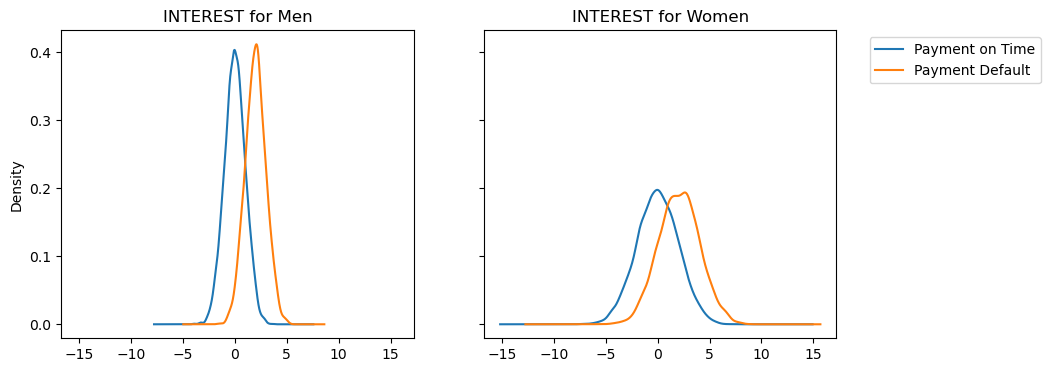

In [16]:
# create a subplot with distributions of interes rates by SEX, Target
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)

# -------------------
# Men
# -------------------
# Men, no default
_ = X["Interest"][(A == 1) & (Y == 0)].plot(kind="kde", label="Payment on Time", ax=ax[0], title="INTEREST for Men")
# Men, default
_ = X["Interest"][(A == 1) & (Y == 1)].plot(kind="kde", label="Payment Default", ax=ax[0])


# -------------------
# Women
# -------------------
# Women, no default
_ = X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax[1], legend=True,
    title="INTEREST for Women",
)
# Women, default
_ = X["Interest"][(A == 2) & (Y == 1)].plot(kind="kde", label="Payment Default", ax=ax[1], legend=True).legend(bbox_to_anchor=(1.6, 1))

Training an initial model
=========================

In this section, we will train a fairness-unaware model on the training
data. However because of the imbalances in the dataset, we will first
resample the training data to produce a new balanced training dataset.


In [17]:
def resample_training_data(X_train: pd.DataFrame, 
                           Y_train: pd.Series, 
                           A_train: pd.Series) -> Tuple[Union[pd.DataFrame, pd.Series]]:
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [18]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

In [19]:
print('X_train: ', X_train.shape)
print('X_test:', X_test.shape, '\n')

print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape,  '\n')

print('A_train: ', A_train.shape)
print('A_test: ', A_test.shape,  '\n')

X_train:  (19500, 32)
X_test: (10500, 32) 

y_train:  (19500,)
y_test:  (10500,) 

A_train:  (19500,)
A_test:  (10500,) 



In [20]:
print('Target distribution:')
print('Train: \n', y_train.value_counts(normalize=True), '\n')
print('Test: \n', y_test.value_counts(normalize=True))

Target distribution:
Train: 
 default
0    0.778821
1    0.221179
Name: proportion, dtype: float64 

Test: 
 default
0    0.778762
1    0.221238
Name: proportion, dtype: float64


In [21]:
X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

In [22]:
print('X_train: ', X_train.shape)
print('X_test:', X_test.shape, '\n')

print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape,  '\n')

print('A_train: ', A_train.shape)
print('A_test: ', A_test.shape,  '\n')

X_train:  (8626, 32)
X_test: (10500, 32) 

y_train:  (8626,)
y_test:  (10500,) 

A_train:  (8626,)
A_test:  (10500,) 



In [23]:
print('Target distribution:')
print('Train: \n', y_train.value_counts(normalize=True), '\n')
print('Test: \n', y_test.value_counts(normalize=True))

Target distribution:
Train: 
 default
1    0.5
0    0.5
Name: proportion, dtype: float64 

Test: 
 default
0    0.778762
1    0.221238
Name: proportion, dtype: float64


At this stage, we will train a *gradient-boosted tree classifier* using
the `lightgbm` package on the balanced training dataset. When we
evaluate the model, we will use the unbalanced testing dataset.


In [24]:
lgb_params: Dict[str, Any] = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", lgb.LGBMClassifier(**lgb_params)),
    ]
)

estimator.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, objective='binary',
                                random_state=1234))])

We compute the *binary predictions* and the *prediction probabilities*
for the testing data points.


In [25]:
# predict probabilities
Y_pred_proba: np.array = estimator.predict_proba(X_test)[:, 1]

# predict binary iutput
Y_pred: np.array = estimator.predict(X_test)

From the *ROC Score*, we see the model appears to be differentiating
between *true positives* and *false positives* well. This is to be
expected given the `INTEREST` feature provides a strong discriminant
feature for the classification task.


In [26]:
# ROC AUC - overall
roc_auc_score(y_test, Y_pred_proba)

0.8782234705862874

Feature Importance of the Unmitigated Classifier
================================================

As a model validation check, let\'s explore the feature importances of
our classifier. As expected, our synthetic feature `INTEREST` has the
highest feature importance because it is highly correlated with the
target variable, by construction.


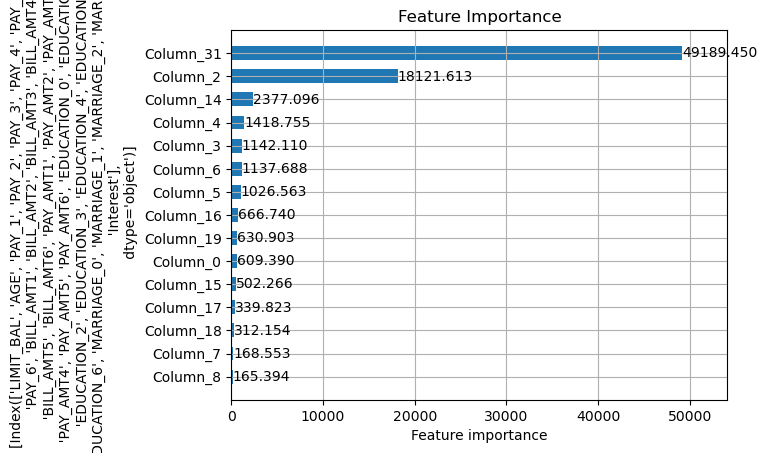

In [27]:
# feature importance
lgb.plot_importance(
    estimator.named_steps["classifier"],
    height=0.6,
    title="Feature Importance",
    importance_type="gain",
    max_num_features=15,
)
_ = plt.ylabel([X.columns])

In [28]:
# print top-3 important features
X_train.iloc[:, [31, 2, 14]].head()

,Interest,PAY_1,PAY_AMT1
0,2.942870,2,0
1,-0.381951,-1,0
3,-0.625304,0,2000
4,-0.720589,-1,2000
8,0.031393,0,3329


Fairness assessment of unmitigated model
========================================

Now that we have trained our initial fairness-unaware model, let\'s
perform our fairness assessment for this model. When conducting a
fairness assessment, there are three main steps we want to perform:

1.  Identify who will be harmed.
2.  Identify the types of harms we anticipate.
3.  Define fairness metrics based on the anticipated harms.

Who will be harmed?
-------------------

Based on the incident with *Apple* credit card mentioned at the
beginning of this notebook, we believe the model may incorrectly predict
women will default on the credit loan. The system may unfairly allocate
less loans to women and over-allocate loans to men.


Types of harm experienced
=========================

When discussing fairness in AI systems, the first step is understanding
what types of harms we anticipate the system may produce. Using the[harms taxonomy in the Fairlearn User Guide](https://fairlearn.org/v0.10/user_guide/fairness_in_machine_learning.html#types-of-harms), 

- We expect this system to produce *harms of allocation*.
- In
addition, we also anticipate the long-term impact on an individual\'s
credit score if an individual is unable to repay a loan they receive or
if they are rejected for a loan application.

**A harm of allocation**

It occurs when an AI system extends or withholds resources, opportunities,
information. 

In this scenario, the AI system is extending or withholding
financial assets from individuals. A review of historical incidents
shows these types of automated lending decision systems may discriminate
unfairly based on sex.

**Negative impact of credit score**

A secondary harm that is somewhat unique to credit lending decisions is
the long-term impact on an individual\'s credit score. In the United
States, a [FICO credit
score](https://www.investopedia.com/terms/c/credit_score.asp) is a
number between 300 and 850 that represents a customer\'s
*creditworthiness*. An applicant\'s *credit score* is used by many
financial institutions for lending decisions. An applicant\'s *credit
score* usually increases after a successful repayment of a loan and
decreases if the applicant fails to repay the loan.

When applying for a credit loan, there are three major outcomes:

1.  The individual receives the credit loan and pays back the loan. In
    this scenario, we expect the individual\'s credit score to increase
    as a result of the successful repayment of the loan.
2.  The individual receives the credit loan but defaults on the loan. In
    this scenario, the individual\'s credit score will drop drastically
    due to the failure to repay the loan. In the modeling process, this
    outcome is tied to a **false negative** (the model predicts the
    individual will repay the loan, but the individual is unsuccessful
    in doing so).
3.  In certain countries, such as the United States, an individual
    receives a small drop (up to five points) to their credit score
    after a lender performs a *hard inquiry* on the applicant\'s credit
    history. If the applicant applies for a loan but does not receive
    it, the small decrease in their credit score will impact their
    ability to successfully apply for a future loan. In the modeling
    process, this outcome is tied to the **selection rate** (the
    proportion of positive predictions outputted by the model).

**Prevention of wealth accumulation**

One other type of harm we anticipate in this scenario is the long-term
effects of *denying loans to applicants who would have successfully paid
back the loan*. By receiving a loan, an applicant is able to purchase a
home, start a business, or pursue some other economic activity that they
are not able to do otherwise. These outcomes are tied to **false
positive error** rates in which the model predicts an applicant will
default on the loan, but the individual would have successfully paid the
loan back. In the United States, the practice of redlining, denying
mortgage loans and other financial services to predominantly Black or
other minority communities, has resulted in a vast racial wealth gap
between white and Black Americans. Although the practice of redlining
was banned in 1968 with the *Fair Housing Act*, the long-term impact of
these practices is
reflected in the lack of economic investment in Black communities, and
Black applicants are denied loans at a higher rate compared to white
Americans.

Define fairness metrics based on harms
--------------------------------------

Now that we have identified the relevant harms we anticipate users will
experience, we can define our fairness metrics. In addition to the
metrics, we will quantify the uncertainty around each metric using
*custom functions* to compute the *standard error* for each metric at
the $\alpha=0.95$ confidence level.


In [29]:
def compute_error_metric(metric_value: float, sample_size: int) -> float:
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred) -> float:
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred) -> float:
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred) -> float:
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2

In [30]:
# define a dictionary of metrics names and functions to provide them to `MetricFrame`
# everything with naming like `..._error` - compute standard error for a `...` metric
fairness_metrics: Dict[str, Any] = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

Select a subset of metrics to report to avoid information overload


In [31]:
# metrics to make a final report on
metrics_to_report: List[str] = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

To compute the disaggregated performance metrics, we will use the
`MetricFrame` object within the Fairlearn library. 

We will pass in our
dictionary of metrics `fairness_metrics`, along with our test labels
`y_test` and test predictions `Y_pred`. 

In addition, we pass in the
*sensitive\_features* `A_test` to disaggregate our model results.

Instantiate the MetricFrame for the unmitigated model


In [32]:
# create a MetricFrame object
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

In [33]:
# metricframe_unmitigated.overall - an attribute with pd.Series 
# of metrics from `fairness_metrics` computed by the whole  dataset

# we'd like to look only at ones from `metrics_to_report`
print('Overall metrics:')
metricframe_unmitigated.overall[metrics_to_report]

Overall metrics:


balanced_accuracy      0.801682
false_positive_rate    0.207656
false_negative_rate    0.188980
dtype: float64

In [34]:
# metricframe_unmitigated.by_group - an attribute with a dataframe 
# with all the metrics from the `fairness_metrics` dictionary by sensitive group

# we'd like to look only at `metrics_to_report`
print('Metrics by SEX')
metricframe_unmitigated.by_group[metrics_to_report]

Metrics by SEX


,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.754349,0.255571,0.23573
male,0.871396,0.132979,0.12423


In [35]:
# metricframe_unmitigated.difference() - the method computes differences 
# between metrics computer per a sensitive group (all from `fairness_metrics`)
# output: pd.Series with metrics from `fairness_metrics`

# we'd like to look only at ones from `metrics_to_report`
print('Differences by SEX:\n')
print(metricframe_unmitigated.difference()[metrics_to_report])

Differences by SEX:

balanced_accuracy      0.117046
false_positive_rate    0.122592
false_negative_rate    0.111500
dtype: float64


In [36]:
def plot_group_metrics_with_error_bars(metricframe: MetricFrame, 
                                       metric: str, 
                                       error_name: str) -> None:
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    # extract metrics
    grouped_metrics: pd.DataFrame  = metricframe.by_group
    
    # extract a metric
    point_estimates: pd.Series = grouped_metrics[metric]
    
    # extract standard error to build CI
    error_bars: pd.Series = grouped_metrics[error_name]
    
    # Confidence intervals
    lower_bounds: pd.Series = point_estimates - error_bars
    upper_bounds: pd.Series = point_estimates + error_bars

    # make fancy names of x-axis (names of sensitive groups)
    x_axis_names: List[str] = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    
    # CI
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    # estimated metrics
    plt.scatter(x_axis_names, point_estimates, s=25)
    
    # make a plot look fancy
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

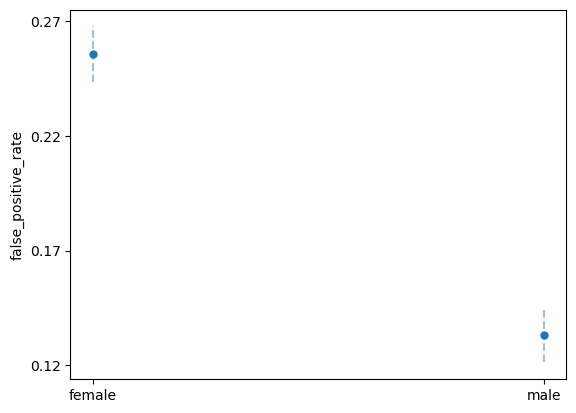

In [37]:
# plot CI for False Positive Ratio
_ = plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

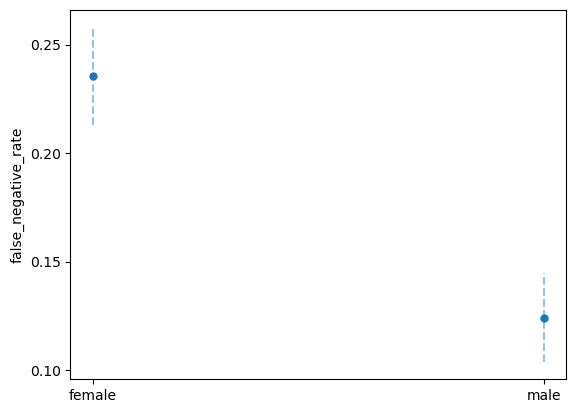

In [38]:
# plot CI for False Negative Ratio
_ = plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

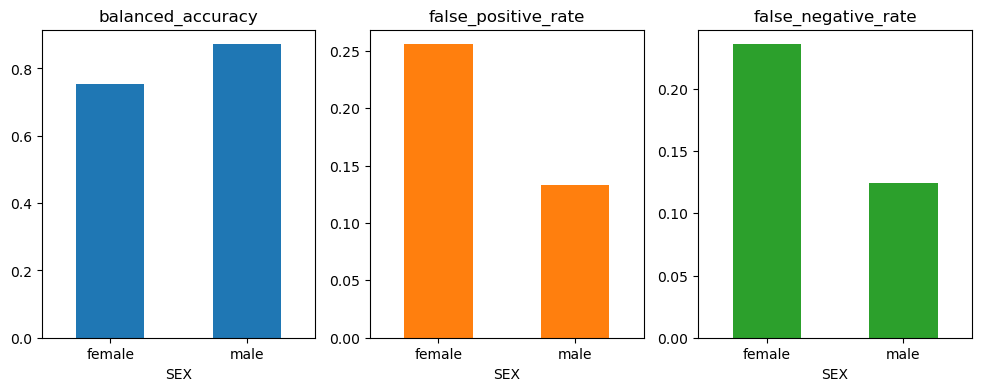

In [39]:
# overall plot with overall 
#  - balanced accuracy, 
# - FPR
# - FNR

# metricframe_unmitigated.by_group[metrics_to_report] - a pd.DataFrame with SEX as index
_ = metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

Finally, let\'s compute the `equalized_odds_difference` for this
unmitigated model. The `equalized_odds_difference` is the maximum of the
`false_positive_rate_difference` and `false_negative_rate_difference`.
In our lending context, both *false\_negative\_rate\_disparities* and
*false\_positive\_rate\_disparities* result in fairness-related harms.
Therefore, we attempt to minimize both of these metrics by minimizing
the `equalized_odds_difference`.


In [40]:
balanced_accuracy_unmitigated: float = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated: float = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)
# should be 'close' to 0
print('Equalized odds (unmitigated): ', equalized_odds_unmitigated)

Equalized odds (unmitigated):  0.12259244704344596


One key assumption here is we assume that *false positives* and *false
negatives* have the equally adverse costs to each group. In practice, we
would develop some weighting mechanism to assign a weight to each *false
negative* and *false positive* event.

Mitigating Unfairness in ML models
==================================

In the previous section, we identified disparities in the model\'s
performance with respect to `SEX`. In particular, we found that model
produces a significantly higher `false_negative_rate` and
`false_positive_rate` for the applicants labeled `female` compared to
those labeled `male`. In the context of credit decision scenario, this
means the model under-allocates loans to *women* who would have paid the
loan, but over-allocates loans to *women* who go on to default on their
loan.

In this section, we will discuss strategies for mitigating the
performance disparities we found in our unmitigated model. We will apply
two different mitigation strategies:

-   *Postprocessing*: In the postprocessing approach, the outputs of a
    trained classifier are transformed to satisfy some fairness
    criterion.
-   *Reductions*: In the reductions approach, we take in a model class
    and iteratively create a sequence of models that optimize some
    fairness constraint. Compared to the *postprocessing* approach, the
    fairness constraint is satisfied during the model training time
    rather than afterwards.

Postprocessing mitigations: ThresholdOptimizer
----------------------------------------------

In the Fairlearn package, *postprocessing* mitigation is offered through
the `ThresholdOptimizer` algorithm. The
`ThresholdOptimizer` takes in an existing (possibly pre-fit) machine
learning model whose predictions acts as a scoring function to identify
separate thresholds for each *sensitive feature* group. The
`ThresholdOptimizer` optimizes a specified objective metric (in our
case, `balanced_accuracy`) subject to some fairness constraint, resulting in a thresholded version of
the underlying machine learning model.

To instantiate our `ThresholdOptimizer`, we need to specify our fairness
constraint as a model parameter. Because both `false_negative_rate`
disparities and `false_positive_rate` disparities translate into
real-world harms in our scenario, we will aim to minimize the
`equalized_odds` difference as our *fairness constraint*.


In [41]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds",  # Optimize FPR and FNR simultaneously
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)

One key limitation of the `ThresholdOptimizer` is the need for sensitive
features during training and prediction time. If we do not have access
to the `sensitive_features` during prediction time, we cannot use the
`ThresholdOptimizer`.

We pass in `A_train` to the `fit` function with the `sensitive_features`
parameter.


In [42]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)

# generate prediction by a mitigated classifier
# - binary
postprocess_pred: np.array = postprocess_est.predict(X_test, sensitive_features=A_test)

# - probabilities
postprocess_pred_proba: np.array = postprocess_est._pmf_predict(
    X_test, sensitive_features=A_test
)

Fairness assessment of postprocessing model
===========================================


In [43]:
def compare_metricframe_results(mframe_1: MetricFrame, 
                                mframe_2: MetricFrame,
                                metrics: List[str], 
                                names) -> pd.DataFrame:
    """Concatenate the results of two MetricFrames along a subset of metrics.

    Parameters
    ----------
    mframe_1: First MetricFrame for comparison
    mframe_2: Second MetricFrame for comparison
    metrics: The subset of metrics for comparison
    names: The names of the selected metrics

    Returns
    -------
    PandasFrame : Pandas Data Frame
        The concatenation of the two data frames, restricted to the metrics
        specified.

    """
    return pd.concat(
        [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
        keys=names,
        axis=1,
    )

In [44]:
# Balanced accuracy (# should be close to 1)
# for an unmitigated classifier: 0.801682 # expect decreasing for a a mitigated one

# for a mitigated one
bal_acc_postprocess: float = balanced_accuracy_score(y_test, postprocess_pred)
print('Balanced accuracy (mitigated): ', bal_acc_postprocess)

Balanced accuracy (mitigated):  0.7615501855708485


In [45]:
# create a MetricFrame for a postprocessed predictions
metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test,
)

In [46]:
# Overall metrics of an unmitigated classifier:  #we expect quality decrease: 
# balanced_accuracy      0.801682 # expect decrease
# false_positive_rate    0.207656 # expect increase
# false_negative_rate    0.188980 # expect increase

print('Overall metrics:')
print(metricframe_postprocess.overall[metrics_to_report])

Overall metrics:
balanced_accuracy      0.761550
false_positive_rate    0.270270
false_negative_rate    0.206629
dtype: float64


In [47]:
# differences between metrics computer per a sensitive group (all from `fairness_metrics`)

# Differences by SEX of an unmitigated classifier: # expect decrease

# balanced_accuracy      0.117046 # expect decrease, become close to 0
# false_positive_rate    0.122592 # expect decrease, become close to 0
# false_negative_rate    0.111500 # expect decrease, become close to 0

print('Metrics by SEX')
metricframe_postprocess.difference()[metrics_to_report]

Metrics by SEX


balanced_accuracy      0.019392
false_positive_rate    0.002971
false_negative_rate    0.035814
dtype: float64

In [48]:
# Equalized odds difference (# should be 'close' to 0)
# for an unmitigated classifier: 0.12259244704344596

# for a mitigated classifier 
eq_odds_postprocess: float = equalized_odds_difference(
    y_test, postprocess_pred, sensitive_features=A_test
)
print('Equalized odds (mitigated): ', eq_odds_postprocess)

Equalized odds (mitigated):  0.0358140412778194


Now, let\'s compare the performance of our *thresholded* classifier with
the original *unmitigated* model.


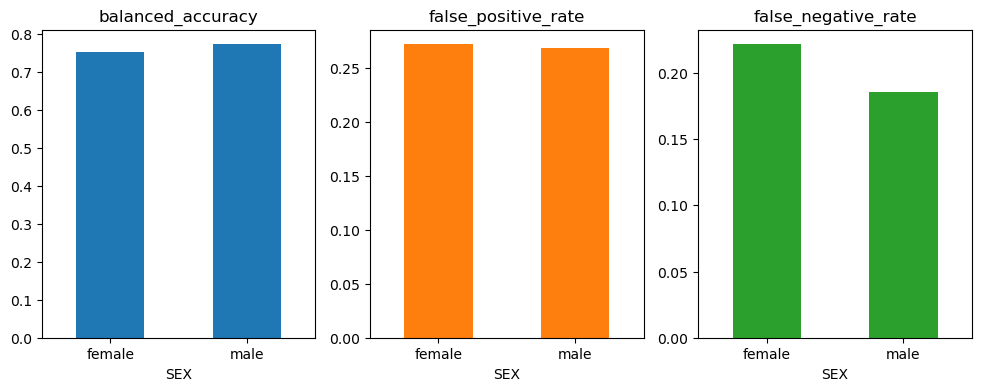

In [49]:
_ = compare_metricframe_results(
    metricframe_unmitigated,
    metricframe_postprocess,
    metrics=metrics_to_report,
    names=["Unmitigated", "PostProcess"],
)

_ = metricframe_postprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

We see that the `ThresholdOptimizer` algorithm achieves a much lower
disparity between the two groups compared to the *unmitigated* model.
However, this does come with the trade-off that the `ThresholdOptimizer`
achieves a lower `balanced_accuracy` score for *male* applicants.

Reductions approach to unfairness mitigation
============================================

In the previous section, we took a fairness-unaware model and used the
`ThresholdOptimizer` to transform the model\'s decision boundary to
satisfy our fairness constraints. One key limitation of the
`ThresholdOptimizer` is needing access to our *sensitive\_feature*
during prediction time.

In this section, we will use the *reductions* approach of Agarwal et. al
(2018) to
produce models that satisfy the fairness constraint without needing
access to the sensitive features at deployment time.

The main reduction algorithm in Fairlearn is `ExponentiatedGradient`.
The algorithm creates a sequence of re-weighted datasets and retrains
the wrapped classifier on each of the datasets. This re-training process
is guaranteed to find a model that satisfies the fairness constraints
while optimizing the performance metric.

The model returned by `ExponentiatedGradient` consists of several inner
models, returned by a wrapped estimator.

To instantiate an `ExponentiatedGradient` model, we pass in two
parameters:

-   a base `estimator` (object that supports training)
-   fairness `constraints` (object of type
    `fairlearn.reductions.Moment`)

When passing in a fairness *constraint* as a `Moment`, we can specify an
`epsilon` value representing the maximum allowed difference or ratio
between our largest and smallest value. For example, in the below code,
`EqualizedOdds(difference_bound=epsilon)` means that we are using
`EqualizedOdds` as our fairness constraint, and we will allow a maximal
difference of `epsilon` between our largest and smallest *equalized
odds* value.


In [50]:
def get_expgrad_models_per_epsilon(estimator: Any, 
                                   epsilon: float, 
                                   X_train: pd.DataFrame, 
                                   y_train: pd.Series, 
                                   A_train: pd.Series) -> List[Any]:
    """Instantiate and train an ExponentiatedGradient model on the
    balanced training dataset.

    Parameters
    ----------
    Estimator: Base estimator to contains a fit and predict function.
    Epsilon: Float representing maximum difference bound for the fairness Moment constraint

    Returns
    -------
    List of Predictrs: 
        List of inner model predictors learned by the ExponentiatedGradient
        model during the training process.

    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator,
        sample_weight_name='classifier__sample_weight',
        constraints=EqualizedOdds(difference_bound=epsilon),
    )
    # Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors

Because the *performance-fairness trade-off* learned by the
`ExponentiatedGradient` model is sensitive to our chosen `epsilon`
value, we can treat `epsilon` as a *hyperparameter* and iterate over a
range of potential values. Here, we will train two
`ExponentiatedGradient` models, one with `epsilon=0.01` and the second
with `epsilon=0.02`, and store the inner models learned through each of
the training processes.

In practice, we recommend choosing smaller values of `epsilon` on the
order of the *square root* of the number of samples in the training
dataset:
$\dfrac{1}{\sqrt{\text{numberSamples}}} \approx \dfrac{1}{\sqrt{25000}} \approx 0.01$


In [51]:
# the maximum allowed difference or ratio between our largest and smallest values
epsilons: List[float] = [0.01, 0.02]

In [52]:
# trained models on the re-weighted datasets:
all_models: Dict[str, Any] = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(
        estimator=estimator,
        epsilon=eps,
        X_train=X_train,
        y_train=y_train,
        A_train=A_train,
    )

[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4313, number of negative: 

In [53]:
for epsilon, models in all_models.items():
    print(
        f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models"
    )

For epsilon 0.01, ExponentiatedGradient learned 17 inner models
For epsilon 0.02, ExponentiatedGradient learned 19 inner models


Here, we can see all the inner models learned for each value of
`epsilon`. With the `ExponentiatedGradient` model, we specify an
`epsilon` parameter that represents the maximal disparity in our
fairness metric that our final model should satisfy. For example, an
`epsilon=0.02` means that the training value of the *equalized odds
difference* of the returned model is at most `0.02` (if the algorithm
converges).

Reviewing inner models of ExponentiatedGradient
===============================================

In many situations due to regulation or other technical restrictions,
the randomized nature of `ExponentiatedGradient` algorithm may be
undesirable. In addition, the multiple inner models of the algorithm
introduce challenges for model interpretability. One potential
workaround to avoid these issues is to select one of the inner models
and deploy it instead.

In the previous section, we trained multiple `ExponentiatedGradient`
models at different `epsilon` levels and collected all the inner models
learned by this process. When picking a suitable inner model, we
consider trade-offs between our two metrics of interest: *balanced error
rate* and *equalized odds difference*. Since our focus is on these two
metrics, we will filter out the models that are outperformed in both of
the metrics by some other model (we refer to these as *\"dominated\"*
models), and plot just the remaining *\"undominated\"* models.


In [54]:
def is_pareto_efficient(points) -> np.array:
    """Filter a NumPy Matrix to remove rows that are strictly dominated by
    another row in the matrix. Strictly dominated means the all the row values
    are greater than the values of another row.

    Parameters
    ----------
    Points: NumPy array (NxM) of model metrics.
        Assumption that smaller values for metrics are preferred.

    Returns
    -------
    Boolean Array:
        Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(
                points[is_efficient] < c, axis=1
            )
            is_efficient[i] = True
    return is_efficient

In [55]:
def filter_dominated_rows(points) -> Tuple[np.array, pd.Series]:
    """Remove rows from a DataFrame that are monotonically dominated by
    another row in the DataFrame.

    Parameters
    ----------
    Points: DataFrame where each row represents the summarized performance
            (balanced accuracy, fairness metric) of an inner model.

    Returns
    -------
    pareto mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
    masked_DataFrame: DataFrame with dominated rows filtered out.

    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]

In [56]:
def aggregate_predictor_performances(predictors: List[Any], 
                                     metric: Any, 
                                     X_test: pd.DataFrame, 
                                     Y_test: pd.Series, 
                                     A_test: Union[pd.Series] = None) -> List[float]:
    """Compute the specified metric for all classifiers in predictors.
    If no sensitive features are present, the metric is computed without
    disaggregation.

    Parameters
    ----------
    predictors: A set of classifiers to generate predictions from.
    metric: The metric (callable) to compute for each classifier in predictor
    X_test: The data features of the testing data set
    Y_test: The target labels of the teting data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    List:
        of performance scores for each classifier in predictors, for the
        given metric.
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [
            metric(Y_test, Y_sweep, sensitive_features=A_test)
            for Y_sweep in all_predictions
        ]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [57]:
def model_performance_sweep(models_dict: Dict[str, Any], 
                            X_test: pd.DataFrame, 
                            y_test: pd.Series, 
                            A_test: pd.Series) -> pd.DataFrame:
    """Compute the equalized_odds_difference and balanced_error_rate for a
    given list of inner models learned by the ExponentiatedGradient algorithm.
    Return a DataFrame containing the epsilon level of the model, the index
    of the model, the equalized_odds_difference score and the balanced_error
    for the model.

    Parameters
    ----------
    models_dict: Dictionary mapping model ids to a model.
    X_test: The data features of the testing data set
    y_test: The target labels of the testing data set
    A_test: The sensitive feature of the testing data set.

    Returns
    -------
    PandasFrame : Pandas Data Frame
        where each row represents a model (epsilon, index) and its performance metrics
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(
            models, equalized_odds_difference, X_test, y_test, A_test
        )
        bal_acc_score = aggregate_predictor_performances(
            models, balanced_accuracy_score, X_test, y_test
        )
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((eps, i, score, (1 - bal_acc_score[i])))
    performances_df = pd.DataFrame.from_records(
        performances,
        columns=["epsilon", "index", "equalized_odds", "balanced_error"],
    )
    return performances_df

In [58]:
# a data frame with epssiloms, equlized odds, balances errors
performance_df: pd.DataFrame = model_performance_sweep(all_models, X_test, y_test, A_test)
performance_df.head()

,epsilon,index,equalized_odds,balanced_error
0,0.01,0,0.122592,0.198318
1,0.01,1,0.120384,0.197860
2,0.01,2,0.366542,0.637947
3,0.01,3,0.117107,0.199406
4,0.01,4,0.367404,0.640109


In [59]:
# extract only 'equalized_odds', 'balanced_error' from 'performance_df'
performance_subset: pd.DataFrame = performance_df.loc[
    :, ["equalized_odds", "balanced_error"]
]

In [60]:
# indices of input DataFrame that are not monotonically dominated,
# pd.DataFrame with dominated rows filtered out
mask, pareto_subset = filter_dominated_rows(performance_subset)

In [61]:
# artifacts of not monotonically dominated models
performance_df_masked: pd.DataFrame = performance_df.loc[mask, :]
performance_df_masked.head()

,epsilon,index,equalized_odds,balanced_error
1,0.01,1,0.120384,0.197860
8,0.01,8,0.098136,0.198655
10,0.01,10,0.095925,0.200172
12,0.01,12,0.089024,0.201737
13,0.01,13,0.053065,0.219443


Now, let\'s plot the performance trade-offs between all of our models.


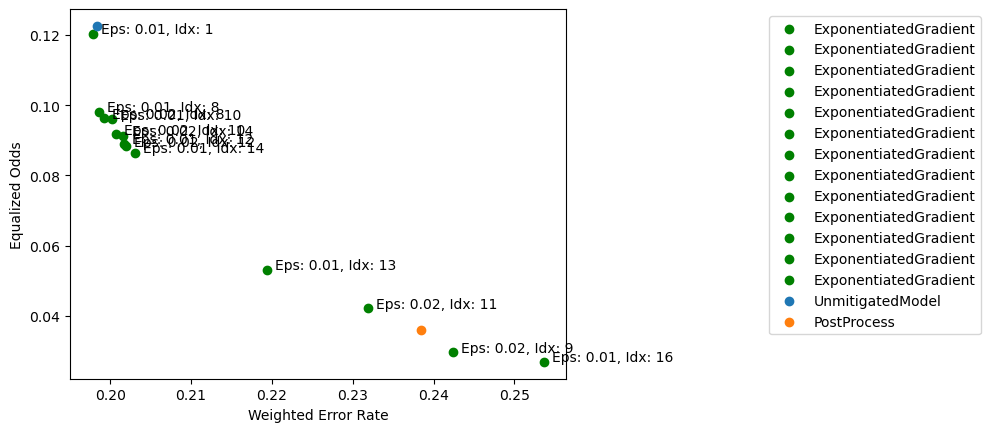

In [62]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(
        bal_error, eq_odds_diff, color="green", label="ExponentiatedGradient"
    )
    # add annotations of the dots of ExponentiatedGradient 
    plt.text(
        bal_error + 0.001,
        eq_odds_diff + 0.0001,
        f"Eps: {epsilon_}, Idx: {int(index_)}",
        fontsize=10,
    )

# add unmitigated equlaized odds and balanced accuracy
plt.scatter(
    1.0 - balanced_accuracy_unmitigated,
    equalized_odds_unmitigated,
    label="UnmitigatedModel",
)

# add post-processed equlaized odds and balanced accuracy
plt.scatter(
    1.0 - bal_acc_postprocess, eq_odds_postprocess, label="PostProcess"
)

# rename axis, add legend
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85, 1))

With the above plot, we can see how the performance of the non-dominated
inner models compares to the original unmitigated model. In many cases,
we see that a reduction in the `equalized_odds_difference` is
accompanied by a small increase in the *weighted error rate*.

Selecting a suitable inner model
================================

One strategy we can use to select a model is creating a *threshold*
based on the *balanced error rate* of the unmitigated model. Then out of
the filtered models, we select the model that minimizes the
`equalized_odds_difference`. The process can be broken down into the
three steps below:

1.  Create threshold based on `balanced_error` of the unmitigated model.
2.  Filter only models whose `balanced_error` are below the threshold.
3.  Choose the model with smallest `equalized_odds` difference.

Within the context of fair lending in the United States, if a financial
institution is found to be engaging in discriminatory behavior, they
must produce documentation that demonstrates the model chosen is the
least discriminatory model while satisfying profitability and other
business needs. In our approach, the business need of profitability is
simulated by thresholding based on the `balanced_error` rate of the
unmitigated model, and we choose the least discriminatory model based on
the smallest `equalized_odds_difference` value.


In [63]:
def filter_models_by_unmitigiated_score(all_models: Dict[float, pd.Series],
                                        models_frames: pd.DataFrame,
                                        unmitigated_score: float,
                                        performance_metric: str = "balanced_error",
                                        fairness_metric: str = "equalized_odds",
                                        threshold: float = 0.01
                                       ) -> Dict[str, Any]:
    """Filter out models whose performance score is above the desired
    threshold. Out of the remaining model, return the models with the best
    score on the fairness metric.

    Parameters
    ----------
    all_models: Dictionary (Epsilon, Index) mapping (epilson, index number) pairs to a Model object
    models_frames: A DataFrame representing each model's performance and fairness score.
    unmitigated_score: The performance score of the unmitigated model.
    performance_metric: The model performance metric to threshold on.
    fairness_metric: The fairness metric to optimize for
    threshold: The threshold padding added to the :code:`unmitigated_score`.

    """
    # Create threshold based on balanced_error of unmitigated model and filter
    models_filtered = models_frames.query(
        f"{performance_metric} <= {unmitigated_score + threshold}"
    )
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    # Choose the model with smallest equalized_odds difference
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index,
    }

In [64]:
best_model: Dict[str, Any] = filter_models_by_unmitigiated_score(
    all_models,
    models_frames=performance_df,
    unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
    threshold=0.015,
)

In [65]:
print(
    f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}"
)

Epsilon for best model: 0.01, Index number: 14.0


In [66]:
inprocess_model: Pipeline = best_model.get("model")

Now we have selected our best inner model, let\'s collect the model\'s
predictions on the test dataset and compute the relevant performance
metrics.


In [67]:
# generate predictions
y_pred_inprocess: np.array = inprocess_model.predict(X_test)

In [68]:
eq_odds_inprocess = equalized_odds_difference(
    y_test, y_pred_inprocess, sensitive_features=A_test
)
print('Equalized odds (inprocess): ', eq_odds_inprocess)

Equalized odds (inprocess):  0.08639984291352787


In [69]:
# compute metrics
metricframe_inprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=y_pred_inprocess,
    sensitive_features=A_test,
)

In [70]:
# Overall metrics of an unmitigated classifier:
# balanced_accuracy      0.801682
# false_positive_rate    0.207656
# false_negative_rate    0.188980

print('Overall metrics:')
metricframe_inprocess.overall[metrics_to_report]

Overall metrics:


balanced_accuracy      0.796910
false_positive_rate    0.194815
false_negative_rate    0.211365
dtype: float64

In [71]:
# Differences by SEX of an unmitigated classifier:

# balanced_accuracy      0.117046
# false_positive_rate    0.122592
# false_negative_rate    0.111500

print('Differences by SEX:\n')
metricframe_inprocess.difference()[metrics_to_report]

Differences by SEX:



balanced_accuracy      0.08394
false_positive_rate    0.08148
false_negative_rate    0.08640
dtype: float64

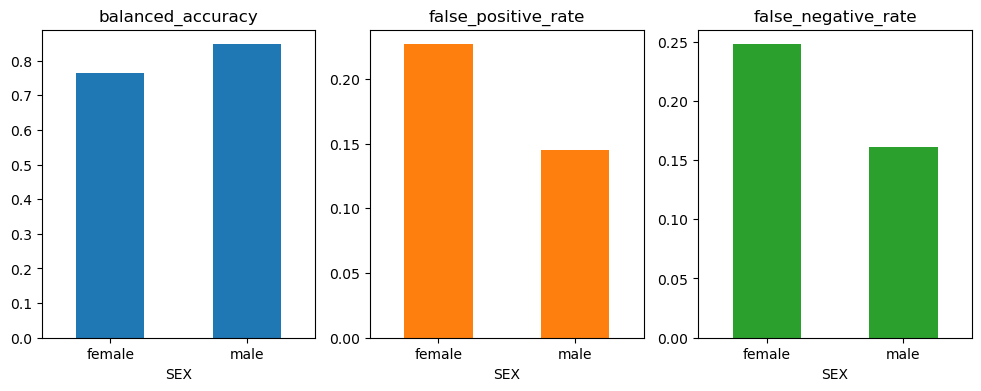

In [72]:
_ = metricframe_inprocess.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

Discuss Performance and Trade-Offs
==================================

Now we have trained two different fairness-aware models using the
*postprocessing* approach and the *reductions* approach. Let\'s compare
the performance of these models to our original fairness-unaware model.


In [73]:
# metric name <-> name of function, which computes a standard error for it
metric_error_pairs: List[Tuple[str]] = [
    ("balanced_accuracy", "balanced_acc_error"),
    ("false_positive_rate", "false_positive_error"),
    ("false_negative_rate", "false_negative_error"),
]

In [74]:
def create_metricframe_w_errors(mframe: MetricFrame, 
                                metrics_to_report: List[str], 
                                metric_error_pair: List[Tuple[str]]) -> pd.DataFrame:
    """Create a pandas data frame with a value of a sensitive characteristic as an index, 
    columns - metrics' names 

    Parameters
    ----------
    mframe: A MetricFrame to extract metrics from
    models_frames: A list of metrics to extract
    unmitigated_score: The performance score of the unmitigated model.
    metric_error_pair: A list of tuples, of a form (metric name, name of function, which computes a standard error for it)

    Returns
    -------
    PandasFrame : Pandas Data Frame
        The concatenation of the two data frames, restricted to the metrics
        specified.

    """
    mframe_by_group = mframe.by_group.copy()
    for (metric_name, error_name) in metric_error_pair:
        mframe_by_group[metric_name] = mframe_by_group[metric_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[error_name] = mframe_by_group[error_name].apply(
            lambda x: f"{x:.3f}"
        )
        mframe_by_group[metric_name] = mframe_by_group[metric_name].str.cat(
            mframe_by_group[error_name], sep="±"
        )
    return mframe_by_group[metrics_to_report]

Report model performance error bars for metrics
===============================================

**Unmitigated model**


In [75]:
create_metricframe_w_errors(
    metricframe_unmitigated, metrics_to_report, metric_error_pairs
)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.754±0.013,0.256±0.012,0.236±0.023
male,0.871±0.012,0.133±0.012,0.124±0.021


In [76]:
pd.DataFrame(metricframe_unmitigated.overall[metrics_to_report]).T

,balanced_accuracy,false_positive_rate,false_negative_rate
0,0.801682,0.207656,0.18898


**ExponentiatedGradient model**


In [77]:
create_metricframe_w_errors(
    metricframe_inprocess, metrics_to_report, metric_error_pairs
)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.763±0.013,0.227±0.012,0.248±0.023
male,0.847±0.013,0.145±0.012,0.161±0.023


In [78]:
pd.DataFrame(metricframe_inprocess.overall[metrics_to_report]).T

,balanced_accuracy,false_positive_rate,false_negative_rate
0,0.79691,0.194815,0.211365


**ThresholdOptimizer**


In [79]:
create_metricframe_w_errors(
    metricframe_postprocess, metrics_to_report, metric_error_pairs
)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.753±0.013,0.271±0.012,0.222±0.022
male,0.773±0.014,0.268±0.015,0.186±0.024


In [80]:
pd.DataFrame(metricframe_postprocess.overall[metrics_to_report]).T

,balanced_accuracy,false_positive_rate,false_negative_rate
0,0.76155,0.27027,0.206629


We see both of our fairness-aware models yield a slight decrease in the
*balanced\_accuracy* for *male applicants* compared to our
fairness-unaware model. In the *reductions* model, we see a decrease in
the *false positive rate* for *female applicants*. This is accompanied
by an increase in the *false negative rate* for *male applicants*.
However overall, the *equalized odds difference* for the *reductions*
models is lower than that of the original fairness-unaware model.

Conclusion and Discussion
=========================

In this case study, we walked through the process of assessing a credit
decision model for gender-related performance disparities. Our analysis
follows closely the work done in the Microsoft/EY white paper
`dudik2020assessing` where they used
the *Fairlearn* toolkit to perform an audit of a fairness-unaware
tree-based model. We applied a *postprocessing* and *reductions*
mitigation techniques to mitigate the *equalized odds difference* in our
model.

Through the *reductions* process, we generated a model that reduces the
*equalized odds difference* of the original model without a drastic
increase in the *balanced error score*. If this were a real model being
developed a financial institution, the *balanced error score* would be a
proxy for the profitability of the model. By maintaining a relatively
similar *balanced error score*, we\'ve produced a model that preserves
profitability to the firm while producing more fair and equitable
outcomes for women in this scenario.

Designing a Model Card
----------------------

A key facet of Responsible Machine Learning is responsible documentation
practices. 
proposed the model card framework for documentating and reporting model
training details and deployment considerations.

A *model card* contains sections for documenting training and evaluation
dataset descriptions, ethical concerns, and quantitative evaluation
summaries. In practice, we would ideally create a model card for our
model before deploying it in production. Although we will not be
producing a model card in this case study, interested readers can learn
more about creating model cards using the *Model Card Toolkit* from the
[Fairlearn PyCon
tutorial](https://github.com/fairlearn/talks/tree/main/2022_pycon).

Fairness under unawareness
--------------------------

When proving credit models are compliant with fair lending laws,
practitoners may run into the issue of not having access to the
sensitive demographic features. As a result, financial institutions are
often tasked with proving their models are compliant with fair lending
laws by imputing these demographics features. However, these
imputation methods often introduce new fairness-related issues.
